In [2]:
%matplotlib notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [15]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import random
import torch.distributions as dist


import sys
sys.path.append("..")
from replay_buffer import ReplayBuffer

In [4]:
# %matplotlib qt5

## 自适应最大熵系数SAC

In [19]:
class Actor(nn.Module):
    def __init__(self, n_state, n_action, action_bound, hidden_size = 64):
        super(Actor, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_mean = torch.nn.Linear(hidden_size, n_action)
        self.fc_std = torch.nn.Linear(hidden_size, n_action)

        self.action_bound = action_bound

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        mu = self.fc_mean(F.relu(x))
        std = F.softplus(self.fc_std(F.relu(x)))

        normal_dist = dist.Normal(mu, std)
        sample = normal_dist.rsample()
        log_prob = normal_dist.log_prob(sample)

        action = torch.tanh(sample)
        # 修正tanh带来的概率密度变化，确保策略梯度正确
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-6)
        action = action * self.action_bound
        return action, log_prob

        
class Qvalue(nn.Module):
    def __init__(self, n_state, n_action, hidden_size=64):
        super(Qvalue, self).__init__()

        self.fc1 = torch.nn.Linear(n_state + n_action, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = self.fc1(torch.cat([state,action],dim=1))
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x


class AdaptiveSAC:
    def __init__(self, n_state, n_action, n_hidden, action_bound, lr_actor, lr_q, target_entropy, tau, gamma, device="cpu"):
        self.device = torch.device(device)
        
        self.actor = Actor(n_state, n_action, action_bound).to(self.device)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        
        self.q1 = Qvalue(n_state, n_action).to(self.device)
        self.q1_target = Qvalue(n_state, n_action).to(self.device)
        self.q1_opt = torch.optim.Adam(self.q1.parameters(), lr=lr_q)

        self.q2 = Qvalue(n_state, n_action).to(self.device)
        self.q2_target = Qvalue(n_state, n_action).to(self.device)
        self.q2_opt = torch.optim.Adam(self.q2.parameters(), lr=lr_q)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())


        self.gamma = gamma
        self.tau = tau

        self.target_entropy = target_entropy #目标熵大小
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float, requires_grad = True)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr = 1e-4)
        

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action, log_prob = self.actor(state)
        return [action.item()]

    def compute_q_target(self, rewards, next_states, dones):
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob

        q1 = self.q1_target(next_states, next_actions)
        q2 = self.q2_target(next_states, next_actions)
        next_value = torch.min(q1, q2) + self.log_alpha.exp() * entropy

        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data*(1.0 - self.tau) + param.data*self.tau)

    def update(self, transition_dict):
        state = torch.tensor(np.array(transition_dict["states"]), dtype=torch.float32).to(self.device)
        action = torch.tensor(np.array(transition_dict["actions"]), dtype=torch.float32).view(-1, 1).to(self.device)
        reward = torch.FloatTensor(np.array(transition_dict["rewards"])).view(-1, 1).to(self.device)
        next_state = torch.FloatTensor(np.array(transition_dict["next_states"])).to(self.device)
        done = torch.FloatTensor(np.array(transition_dict["dones"])).to(self.device).view(-1, 1).to(self.device)

        # critic网络更新
        td_target = self.compute_q_target(reward, next_state,done)
        td_er = self.q1(state, action)
        q1_loss = torch.mean(F.mse_loss(td_er, td_target.detach()))
        q2_loss = torch.mean(F.mse_loss(self.q2(state, action), td_target.detach()))

        self.q1_opt.zero_grad()
        q1_loss.backward()
        self.q1_opt.step()

        self.q2_opt.zero_grad()
        q2_loss.backward()
        self.q2_opt.step()

        # actor网络更新
        new_actions, log_prob = self.actor(state)
        entropy = -log_prob
        q1_value = self.q1(state, new_actions)
        q2_value = self.q2(state, new_actions)
        actor_loss = torch.mean(- self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        self.soft_update(self.q1, self.q1_target)
        self.soft_update(self.q2, self.q2_target)

        # alpha自适应更新
        alpha_loss = torch.mean((entropy - self.target_entropy).detach()*self.log_alpha.exp())
        self.alpha_opt.zero_grad()
        alpha_loss.backward()
        self.alpha_opt.step()

## SAC训练

In [20]:
def train_off_policy_agent(env, agent, num_episodes, rb, batch_size=64):
    return_list = []
    episode_return = 0

    for epoch in range(num_episodes//10):
    
        for i in tqdm(range(10), position=0, desc=f"###{epoch} : {episode_return}, rb:{len(rb)} "):
            episode_return = 0
            state, _ = env.reset(seed=0)
            done , truncated = False, False
            while not done and not truncated:
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                done = done or truncated
                rb.push(state, action, reward, next_state, done)

                if len(rb) > 100:
                    batch_samples = rb.sample(batch_size)
                    transition_dict = {
                        "states": [x[0] for x in batch_samples],
                        "actions": [x[1] for x in batch_samples],
                        "rewards": [x[2] for x in batch_samples],
                        "next_states": [x[3] for x in batch_samples],
                        "dones": [x[4] for x in batch_samples],
                    }
                    agent.update(transition_dict)
                
                state = next_state
                episode_return += reward
            return_list.append(episode_return)

    return return_list


%matplotlib qt5

def test_agent(agent, env_name):
    env = gym.make(env_name, render_mode="human")

    state, info = env.reset(seed=0)

    print(f"Starting observation: {state}")

    episode_over = False
    total_reward = 0
    action_list = []

    while not episode_over:
        action = agent.take_action(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        # print(f"{action=}")
        action_list.append(action)

    print(f"Episode finished! Total reward: {total_reward}")
    env.close()
    return action_list
    

# action_list = test_agent(agent, env_name)

# %matplotlib inline
# plt.hist(action_list, bins=30, density=True, alpha=0.7)
# plt.show()

## MountainCarContinuous-v0

state space: [-0.9844053   0.03570567]
action space: Box(-1.0, 1.0, (1,), float32)
action bound: 1.0
target_entropy: -0.25


###0 : 0, rb:0 :   0%|          | 0/10 [00:00<?, ?it/s]

###1 : -3.572698140279651, rb:9990 :   0%|          | 0/10 [00:00<?, ?it/s]

###2 : -3.5381067721089217, rb:19980 :   0%|          | 0/10 [00:00<?, ?it/s]

###3 : -3.787167119458742, rb:29970 :   0%|          | 0/10 [00:00<?, ?it/s]

###4 : -4.259666025017431, rb:39960 :   0%|          | 0/10 [00:00<?, ?it/s]

###5 : 89.07346463298416, rb:47608 :   0%|          | 0/10 [00:00<?, ?it/s]

###6 : -5.671808904043731, rb:55424 :   0%|          | 0/10 [00:00<?, ?it/s]

###7 : 90.68374990573746, rb:59469 :   0%|          | 0/10 [00:00<?, ?it/s]

###8 : 89.08384348186257, rb:61172 :   0%|          | 0/10 [00:00<?, ?it/s]

###9 : 92.30954000479157, rb:62302 :   0%|          | 0/10 [00:00<?, ?it/s]

###10 : 93.8411664157002, rb:63015 :   0%|          | 0/10 [00:00<?, ?it/s]

###11 : 93.65772022380982, rb:63691 :   0%|          | 0/10 [00:00<?, ?it/s]

###12 : 93.66708216463192, rb:64361 :   0%|          | 0/10 [00:00<?, ?it/s]

###13 : 93.19656889794959, rb:65048 :   0%|          | 0/10 [00:00<?, ?it/s]

###14 : 92.97813422093758, rb:65764 :   0%|          | 0/10 [00:00<?, ?it/s]

###15 : 92.64762884312094, rb:66562 :   0%|          | 0/10 [00:00<?, ?it/s]

###16 : 92.06313030593111, rb:67477 :   0%|          | 0/10 [00:00<?, ?it/s]

###17 : 92.45315002329826, rb:68324 :   0%|          | 0/10 [00:00<?, ?it/s]

###18 : 92.6748999022273, rb:69118 :   0%|          | 0/10 [00:00<?, ?it/s]

###19 : 93.24797783025777, rb:69858 :   0%|          | 0/10 [00:00<?, ?it/s]

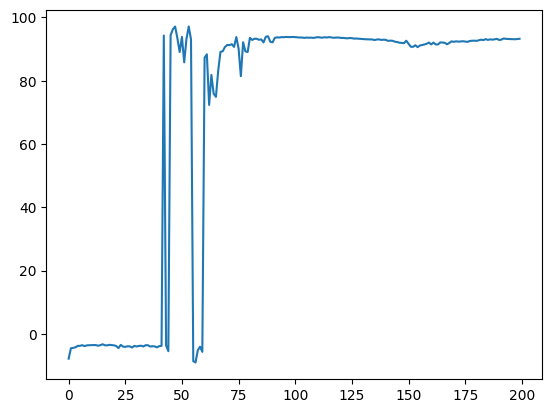

In [28]:
actor_lr = 1e-3
critic_lr = 1e-3
num_episodes = 200

device = "cpu"
env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"

env = gym.make(env_name)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
target_entropy = -env.action_space.shape[0]/4

print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
print(f"action bound: {action_bound}")
print(f"target_entropy: {target_entropy}")


agent = AdaptiveSAC(n_state=state_dim, n_action=action_dim, n_hidden=64, action_bound=action_bound, lr_actor=actor_lr, lr_q=critic_lr, target_entropy = target_entropy, tau=0.02,gamma=0.9999)

replay_buffer = ReplayBuffer(capacity=100000)
return_list = train_off_policy_agent(env, agent, num_episodes,replay_buffer)

%matplotlib inline
plt.plot(return_list)
plt.show()

In [25]:
action_list = test_agent(agent, env_name)

Starting observation: [-0.47260767  0.        ]
Episode finished! Total reward: -1.1236387435196442


## Pendulum

state space: [-0.91282135  0.09728165 -6.60525   ]
action space: Box(-2.0, 2.0, (1,), float32)
action bound: 2.0


###0 : 0, rb:0 :   0%|          | 0/10 [00:00<?, ?it/s]

###1 : -1433.4190356891036, rb:2000 :   0%|          | 0/10 [00:00<?, ?it/s]

###2 : -1103.3523785853165, rb:4000 :   0%|          | 0/10 [00:00<?, ?it/s]

###3 : -881.3824425964286, rb:6000 :   0%|          | 0/10 [00:00<?, ?it/s]

###4 : -1056.2256007900164, rb:8000 :   0%|          | 0/10 [00:00<?, ?it/s]

###5 : -844.5260109869706, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###6 : -703.864087195124, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###7 : -640.3454779531272, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###8 : -633.8044712755607, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###9 : -518.2735012161908, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###10 : -1360.2653582504304, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###11 : -518.9539935291667, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###12 : -509.92085110757995, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###13 : -635.7914935805275, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###14 : -636.0405243788464, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###15 : -505.82295125648693, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###16 : -378.16656914050196, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###17 : -138.12301148423475, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###18 : -135.34625453442413, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###19 : -136.5148973020632, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###20 : -135.30567582679944, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###21 : -135.49035600143844, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###22 : -135.89028227434892, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###23 : -135.99734837640185, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###24 : -137.67175987560208, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###25 : -134.57991857168318, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###26 : -135.88924476159585, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###27 : -135.63294842916997, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###28 : -135.16506672562554, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###29 : -137.64320605880351, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###30 : -137.58088090489517, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###31 : -137.63655933463977, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###32 : -135.50647813916353, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###33 : -135.6279523833767, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###34 : -136.3110551550844, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###35 : -135.5931569690013, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###36 : -136.17120915955854, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###37 : -136.0214196291083, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###38 : -134.94655775929752, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###39 : -135.5030620474292, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###40 : -135.563840465126, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###41 : -133.9308170096085, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###42 : -133.81496719997716, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###43 : -134.71252140688708, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###44 : -135.2290191209812, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###45 : -134.82405393767422, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###46 : -133.9443612363618, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###47 : -134.2989988930911, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###48 : -134.05961117553412, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###49 : -133.7910585691681, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

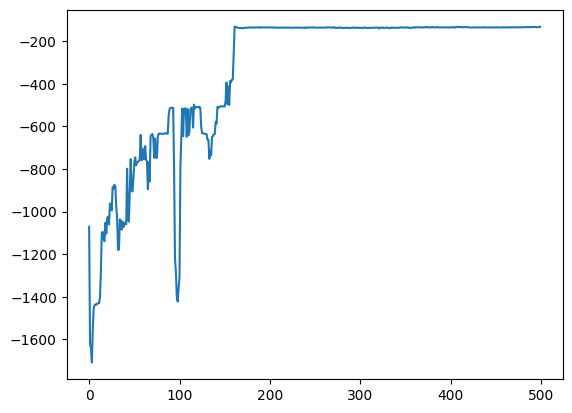

Starting observation: [ 0.6520163   0.758205   -0.46042657]
Episode finished! Total reward: -132.01477426069613


In [26]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 500

device = "cpu"
env_name = "Pendulum-v1"

env = gym.make(env_name)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
target_entropy = -env.action_space.shape[0]


print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
print(f"action bound: {action_bound}")

agent = AdaptiveSAC(n_state=state_dim, n_action=action_dim, n_hidden=64, action_bound=action_bound, lr_actor=actor_lr, lr_q=critic_lr, target_entropy = target_entropy, tau=0.005,gamma=0.99)

replay_buffer = ReplayBuffer(capacity=10000)
return_list = train_off_policy_agent(env, agent, num_episodes,replay_buffer)

%matplotlib inline
plt.plot(return_list)
plt.show()

action_list = test_agent(agent, env_name)